# 개요

Random Forest를 사용하여 이호준이 제안하는 방식으로 재학습에 걸리는 시간과 성능을 체크한다.

* 특징정보 : api, api_lv
* 수집한 apk : 2014~2020

In [4]:
from tqdm import tqdm
import numpy as np
import os
import pandas as pd
from itertools import product
import time
import warnings
import joblib
import shutil


from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [5]:
warnings.filterwarnings(action='ignore')

# 전처리

In [6]:
outlier_value = 50

train_X_dict, train_y_dict, test_X_dict, test_y_dict = dict(),dict(),dict(),dict()
train_X_dict2, test_X_dict2, = dict(),dict()

for i, year in enumerate(range(2014,2021)):
    df1 = pd.read_csv(f'./csv_5000/csv_5000/{year}_benign_api.csv', index_col=0)
    df2 = pd.read_csv(f'./csv_5000/csv_5000/{year}_malware_api.csv', index_col=0)
    df1['year']=str(year-2000)
    df1['b/m']=0
    df2['year']=str(year-2000)
    df2['b/m']=1
    
    train_X_dict[year] = pd.concat([df1.iloc[1000:,:-2],df2.iloc[1000:,:-2]])
    train_y_dict[year] = pd.concat([df1.iloc[1000:,-2:],df2.iloc[1000:,-2:]])
    test_X_dict[year] = pd.concat([df1.iloc[:1000,:-2],df2.iloc[:1000,:-2]])
    test_y_dict[year] = pd.concat([df1.iloc[:1000,-2:],df2.iloc[:1000,-2:]])
    
    
    df3 = pd.read_csv(f'./ex_csv/csv/{year}_benign_lv.csv', index_col=0).loc[df1.index].replace(0,34)
    df4 = pd.read_csv(f'./ex_csv/csv/{year}_malware_lv.csv', index_col=0).loc[df2.index].replace(0,34)
    df3.loc[(df3['platformbuildversioncode'] > 33), 'platformbuildversioncode'] =outlier_value
    df4.loc[(df4['platformbuildversioncode'] > 33), 'platformbuildversioncode'] =outlier_value
    df3.loc[(df3['target'] > 33), 'target'] =outlier_value
    df4.loc[(df4['target'] > 33), 'target'] =outlier_value
    df3.loc[(df3['min'] > 33), 'min'] =outlier_value
    df4.loc[(df4['min'] > 33), 'min'] =outlier_value
    df3.loc[(df3['compile'] > 33), 'compile'] =outlier_value
    df4.loc[(df4['compile'] > 33), 'compile'] =outlier_value
       
    
    
    df3.drop('max', axis=1, inplace=True)
    df4.drop('max', axis=1, inplace=True)
    
    train_X_dict2[year] = pd.concat([df3.iloc[1000:,:],df4.iloc[1000:,:]])
    test_X_dict2[year] = pd.concat([df3.iloc[:1000,:],df4.iloc[:1000,:]])

In [7]:
def make_model(df_x, df_y, max_depth=0):
    if max_depth:
        model = RandomForestClassifier(random_state=42, max_depth=max_depth)
    else:
        model = RandomForestClassifier(random_state=42)
    start = time.time()
    model.fit(df_x, df_y)
    end = time.time()
    return model, (end-start)*1000

In [8]:
def convert_size(size_bytes):
    import math
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [9]:
def AUT(list_):
    return sum([(list_[i] + list_[i+1])/2 for i, elm in enumerate(list_[:-1])])/(len(list_)-1) 

# Sustainability 실험

In [10]:
dir_path = './ex4'

if os.path.exists(dir_path):
    shutil.rmtree(dir_path)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)

In [11]:
time_list=[]
time_list2=[]
time_list3=[]

size_list=[0]
size_list2=[]
size_list3=[]

score_dict = dict()
f1_dict = dict()

## 모든 연도 학습

In [12]:
for year in range(2014,2021):
    exec(f"bmodel{year-2000}, train_time = make_model(train_X_dict[year], train_y_dict[year]['b/m'])")
    exec(f"joblib.dump(bmodel{year-2000}, './{dir_path}/bmodel{year-2000}.pkl')")
    
    exec(f'time_list.append([{year}, train_time])')
    
    exec(f"f_size = convert_size(sum([os.path.getsize('./{dir_path}/'+file) for file in os.listdir('./{dir_path}/')]))")
    exec(f'size_list.append([{year}, f_size])')

In [13]:
size_list.remove(0)

## 연도별 학습

In [14]:
for i,year in enumerate(range(2014,2021)):
    df = pd.concat([train_X_dict2[j] for j in range(2014,year+1)])
    label = pd.concat([train_y_dict[j]['year'] for j in range(2014,year+1)])
    exec(f'ymodel{year-2000}, train_time = make_model(df, label, 5)')
    exec(f'time_list2.append([{year}, train_time])')
    exec(f'time_list3.append([{year}, train_time + time_list[{i}][1]])')
    
    
    exec(f"joblib.dump(ymodel{year-2000}, './{dir_path}/ymodel{year-2000}.pkl')")
    exec(f"f_size = convert_size(os.path.getsize('./{dir_path}/ymodel{year-2000}.pkl'))")
    exec(f'size_list2.append([{year}, f_size])')
    
    s, fs = float(size_list[i][1].split()[0]), float(f_size.split()[0])
    if 'KB' in f_size:
        fs /= 1024
    f_size_all = str(round(s+fs, 2))+" MB"
    
    exec(f'size_list3.append([{year}, str(round(s+fs, 2))+" MB"])')

## 성능 테스트

In [15]:
ymodel_list = [ymodel14, ymodel15, ymodel16, ymodel17, ymodel18, ymodel19, ymodel20]
bmodel_list = [bmodel14, bmodel15, bmodel16, bmodel17, bmodel18, bmodel19, bmodel20]

In [16]:
def model_pred(model_list, test_df, pred_weight_table):
    a = [model.predict_proba(test_df) for model in model_list]
    y = pred_weight_table 
    for apk_index in range(len(test_df)):
        for year_index in range(len(model_list)):
            a[year_index][apk_index] *= y[apk_index][year_index]
            
    return np.argmax(np.sum(a, axis=0), axis=1)

In [17]:
for train_year in range(14,21):
    score_list=[]
    f1_list=[]
    for test_year in range(2014,2021):
        final_pred=eval(f'model_pred(bmodel_list[:train_year-13], test_X_dict[test_year] ,ymodel{train_year}.predict_proba(test_X_dict2[test_year]))')
        score_list.append(accuracy_score(test_y_dict[test_year]['b/m'], final_pred))
        f1_list.append(f1_score(test_y_dict[test_year]['b/m'], final_pred))
    score_dict[train_year+2000] = score_list
    f1_dict[train_year+2000] = f1_list

# 결과

In [18]:
if not os.path.isdir('./visual4'):
    os.mkdir('./visual4')

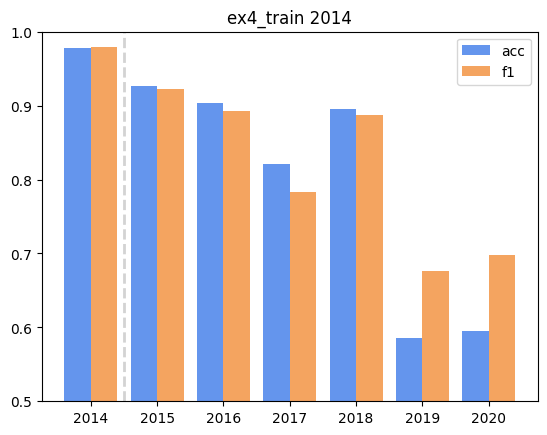

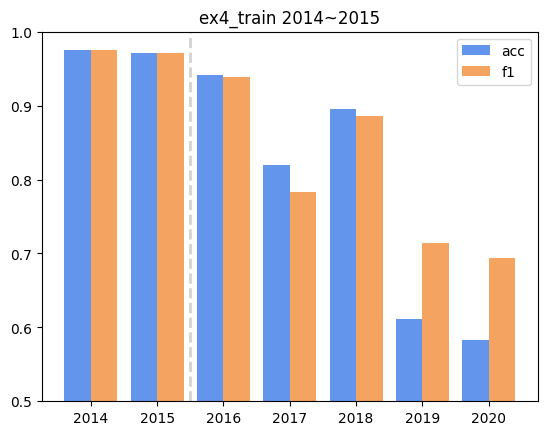

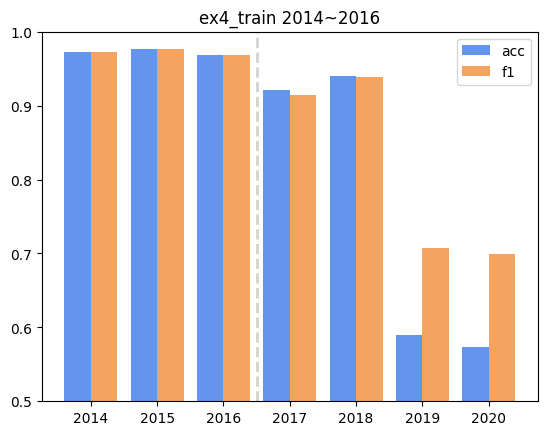

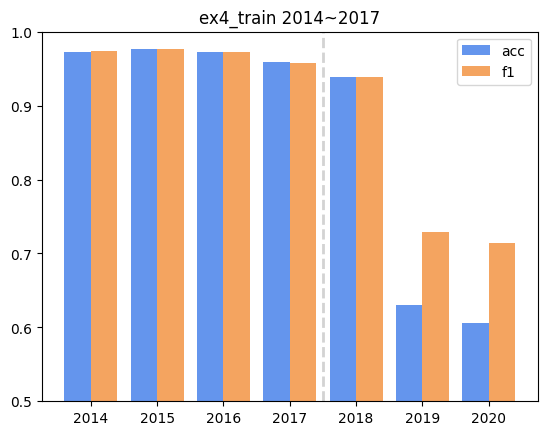

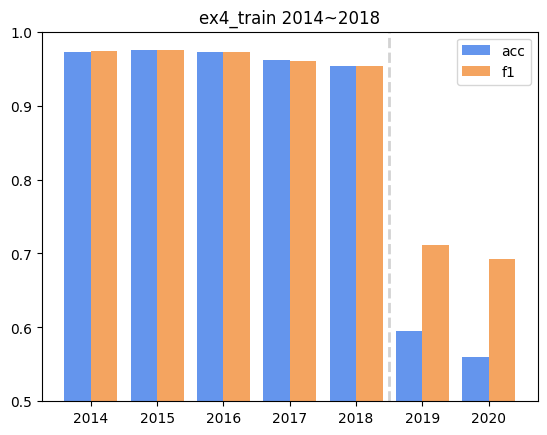

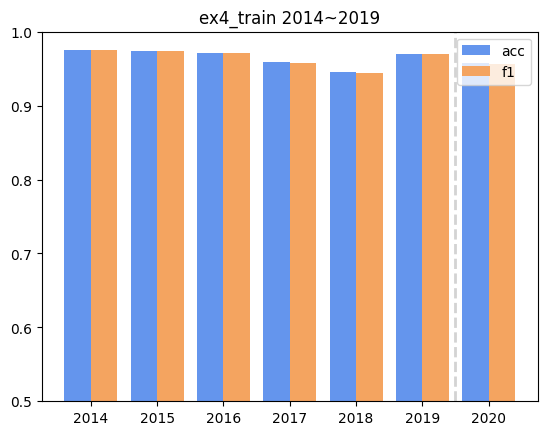

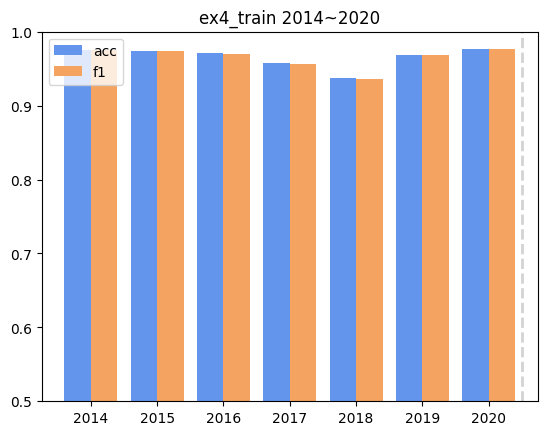

In [19]:
years = range(2014,2021)
x = np.arange(len(years))

for i in range(2014,2021):
    plt.bar(x-0.2 , score_dict[i], label="acc", width=0.4, color='cornflowerblue')
    plt.bar(x+0.2 , f1_dict[i], label="f1", width=0.4, color='sandybrown')
    plt.axvline(i-2013.5, 0, 1, color='lightgray', linestyle='--', linewidth=2)
    if i ==2014:
        plt.title(f'ex4_train 2014')
    else:
        plt.title(f'ex4_train 2014~{i}')
    plt.xticks(x, years)
    plt.ylim(0.5,1)
    plt.legend()
    plt.savefig(f"./visual4/ex4_{i}_acc_f1.png")
    plt.show()

In [20]:
size_list3

[[2014, '7.9 MB'],
 [2015, '16.69 MB'],
 [2016, '23.68 MB'],
 [2017, '28.4 MB'],
 [2018, '32.99 MB'],
 [2019, '36.47 MB'],
 [2020, '39.76 MB']]

In [21]:
df = pd.concat([
    pd.DataFrame(time_list3), 
    pd.DataFrame(size_list3)[1], 
    pd.DataFrame([AUT(score_dict[i]) for i in range(2014,2021)]),
    pd.DataFrame([AUT(f1_dict[i]) for i in range(2014,2021)]),
], axis=1)

df.columns=['year','train_time','model_file_size','accuracy','f1 score']
df

,year,train_time,model_file_size,accuracy,f1 score
0,2014,1770.807028,7.9 MB,0.819833,0.833311
1,2015,1983.523846,16.69 MB,0.836250,0.854640
2,2016,2048.264742,23.68 MB,0.861292,0.890150
3,2017,1944.128513,28.4 MB,0.877917,0.903058
4,2018,3175.280333,32.99 MB,0.870667,0.900740
5,2019,2248.210907,36.47 MB,0.964417,0.963785
6,2020,2470.983028,39.76 MB,0.964250,0.963492


In [22]:
df = pd.concat([
    pd.DataFrame(time_list2), 
    pd.DataFrame(time_list)[1], 
    pd.DataFrame(time_list3)[1], 
    pd.DataFrame(size_list2)[1],
    pd.DataFrame(size_list)[1],
    pd.DataFrame(size_list3)[1],
    pd.DataFrame([AUT(score_dict[i]) for i in range(2014,2021)]),
    pd.DataFrame([AUT(f1_dict[i]) for i in range(2014,2021)]),
], axis=1)

df.columns=['year','year_train_time','b/m_train_time','all_train_time',
            'year model_file_size', 'b/m model_file_size', 'all model_file_size', 
            'accuracy','f1 score']
df

,year,year_train_time,b/m_train_time,all_train_time,year model_file_size,b/m model_file_size,all model_file_size,accuracy,f1 score
0,2014,102.278948,1668.528080,1770.807028,45.59 KB,7.86 MB,7.9 MB,0.819833,0.833311
1,2015,272.593975,1710.929871,1983.523846,447.24 KB,16.25 MB,16.69 MB,0.836250,0.854640
2,2016,357.078075,1691.186666,2048.264742,524.99 KB,23.17 MB,23.68 MB,0.861292,0.890150
3,2017,454.142809,1489.985704,1944.128513,578.48 KB,27.84 MB,28.4 MB,0.877917,0.903058
4,2018,598.846674,2576.433659,3175.280333,617.58 KB,32.39 MB,32.99 MB,0.870667,0.900740
5,2019,687.688351,1560.522556,2248.210907,666.96 KB,35.82 MB,36.47 MB,0.964417,0.963785
6,2020,789.910316,1681.072712,2470.983028,715.88 KB,39.06 MB,39.76 MB,0.964250,0.963492


In [23]:
df.to_csv(f'./ex4_result.csv')

In [24]:
print(len(time_list), len(size_list), len(score_dict), len(f1_dict))

7 7 7 7


In [25]:
score_dict[2019]

[0.975, 0.9745, 0.971, 0.959, 0.9455, 0.97, 0.958]

# 추가실험

하 진짜 ㅠㅠㅠㅠㅠㅠ 개시러댏뱆ㄷㅎ

## 표 1

In [66]:
bmodel_list = [bmodel14, bmodel15, bmodel16, bmodel17, bmodel18, bmodel19, bmodel20]

In [67]:
b=[]
for k,df in test_X_dict.items():
    a=[]
    for i, bm in enumerate(bmodel_list):
        a.append(bm.score(df, test_y_dict[k]['b/m']))
    print(a)
    b.append(a)
df = pd.DataFrame(b)

[0.9785, 0.9465, 0.914, 0.7925, 0.751, 0.529, 0.52]
[0.927, 0.977, 0.9565, 0.7845, 0.76, 0.566, 0.547]
[0.903, 0.952, 0.9775, 0.871, 0.859, 0.6395, 0.6065]
[0.8205, 0.821, 0.948, 0.987, 0.9655, 0.7925, 0.7425]
[0.896, 0.895, 0.942, 0.9565, 0.967, 0.8655, 0.738]
[0.586, 0.6135, 0.5875, 0.638, 0.594, 0.977, 0.9055]
[0.5945, 0.586, 0.5695, 0.6135, 0.5625, 0.958, 0.977]


In [68]:
df.index=[f'test{i}' for i in range(2014,2021)]
df.columns=['14','15','16','17','18','19','20']

In [69]:
df

,14,15,16,17,18,19,20
test2014,0.9785,0.9465,0.9140,0.7925,0.7510,0.5290,0.5200
test2015,0.9270,0.9770,0.9565,0.7845,0.7600,0.5660,0.5470
test2016,0.9030,0.9520,0.9775,0.8710,0.8590,0.6395,0.6065
test2017,0.8205,0.8210,0.9480,0.9870,0.9655,0.7925,0.7425
test2018,0.8960,0.8950,0.9420,0.9565,0.9670,0.8655,0.7380
test2019,0.5860,0.6135,0.5875,0.6380,0.5940,0.9770,0.9055
test2020,0.5945,0.5860,0.5695,0.6135,0.5625,0.9580,0.9770


In [139]:
# # a=pd.DataFrame([1,1,1,1,1,1,1], index=['14','15','16','17','18','19','20'])
# aa=pd.DataFrame(index=['14','15','16','17','18','19','20'])
# for i in range(2014,2021):
#     b=pd.Series(ymodel20.predict(test_X_dict2[i])).value_counts()/2000
# #     print(b)
#     aa['test'+str(i)]=b
# aa=aa.T.fillna(0)b
# aa

In [140]:
# (df*aa).sum(axis=1)

# 표2

In [141]:
dict_index=dict()
for test_year in range(2014,2021):
    dict_index[test_year]=dict()
    for pred_year in range(14,21):
        dict_index[test_year][str(pred_year)]=[]
    for i,v in enumerate(ymodel20.predict(test_X_dict2[test_year])):
        dict_index[test_year][v].append(i)

In [116]:
dict_pred_score=dict()
for test_year in range(2014,2021):
    dict_pred_score[test_year]=dict()
    for pred_year in range(14,21):
        i_list=dict_index[test_year][str(pred_year)]
        X = test_X_dict[test_year].iloc[i_list]
        y = test_y_dict[test_year]['b/m'].iloc[i_list]
        if len(X):
            dict_pred_score[test_year][str(pred_year)]=eval(f'bmodel{pred_year}').score(X,y)
        else:
            dict_pred_score[test_year][str(pred_year)]=0

In [142]:
p1 = pd.DataFrame(columns=range(2014,2021), index=range(14,21))
p2 = pd.DataFrame(columns=range(2014,2021), index=range(14,21))
for test_year in range(2014,2021):
    for pred_year in range(14,21):
        p1[test_year][pred_year]=len(dict_index[test_year][str(pred_year)])
        p2[test_year][pred_year]=dict_pred_score[test_year][str(pred_year)]
p1,p2 = p1.T, p2.T

In [143]:
p1

,14,15,16,17,18,19,20
2014,1959,32,4,3,2,0,0
2015,1015,519,318,124,23,1,0
2016,452,318,447,765,18,0,0
2017,167,218,376,1099,132,8,0
2018,77,99,189,489,698,396,52
2019,24,7,18,41,402,888,620
2020,0,0,1,1,20,439,1539


In [132]:
(0.9795+0.2595+0.2235+0.5495+0.349+0.444+0.7695)/7

0.5106428571428571

In [150]:
p2

,14,15,16,17,18,19,20
2014,0.97805,0.9375,0.75,0.666667,1.0,0,0
2015,0.889655,0.971098,0.962264,0.967742,0.956522,1.0,0
2016,0.734513,0.959119,0.986577,0.96732,0.944444,0,0
2017,0.538922,0.885321,0.93617,0.987261,0.984848,1.0,0
2018,0.818182,0.909091,0.820106,0.948875,0.967049,0.931818,0.884615
2019,0.833333,0.857143,1.0,0.926829,0.539801,0.97973,0.924194
2020,0,0,1.0,0.0,0.85,0.986333,0.97271


In [149]:
pd.concat([(p1*p2), pd.DataFrame((p1*p2).sum(axis=1))], axis=1)

,14,15,16,17,18,19,20,0
2014,1916.0,30.0,3.0,2.0,2.0,0,0,1953.0
2015,903.0,504.0,306.0,120.0,22.0,1.0,0,1856.0
2016,332.0,305.0,441.0,740.0,17.0,0,0,1835.0
2017,90.0,193.0,352.0,1085.0,130.0,8.0,0,1858.0
2018,63.0,90.0,155.0,464.0,675.0,369.0,46.0,1862.0
2019,20.0,6.0,18.0,38.0,217.0,870.0,573.0,1742.0
2020,0,0,1.0,0.0,17.0,433.0,1497.0,1948.0


## 볼필요 없음

In [63]:
for k in range(7):
    cnt=0
    for j in product(*[(i,1-i) for i in df.iloc[k]]):
        if sum(np.array(j)*aa.iloc[k])>=0.5:
            cnt+=j[0]*j[1]*j[2]*j[3]*j[4]*j[5]*j[6]
    print(cnt)

0.9785000000000004
0.9942910729999999
0.9945438953372203
0.9979386116062081
0.993306390157009
0.9769999999999999
0.9770000000000002


In [624]:
# aa=aa.T
aa.index, aa.columns =range(14,21), range(7,14)
df.index, df.columns= range(14,21), range(7,14)

In [625]:
c = aa*df
c

,7,8,9,10,11,12,13
14,0.491730,0.256926,0.117733,0.043795,0.023049,0.004932,0.001005
15,0.249397,0.270690,0.193902,0.118623,0.060838,0.009309,0.001901
16,0.111627,0.191317,0.258193,0.221334,0.113273,0.013595,0.002452
17,0.045457,0.122465,0.237052,0.311792,0.181262,0.027906,0.004848
18,0.026681,0.070780,0.121291,0.174113,0.275999,0.186029,0.059034
19,0.005975,0.009498,0.011849,0.022544,0.123731,0.390915,0.281068
20,0.001315,0.002333,0.002425,0.004701,0.041664,0.290415,0.590761


In [617]:
c.sum(axis=1)

14    0.977353
15    0.933729
16    0.914806
17    0.945474
18    0.929722
19    0.861433
20    0.968299
dtype: float64

In [618]:
score_dict[2020]

[0.9755, 0.9745, 0.9705, 0.958, 0.9375, 0.969, 0.9765]

In [619]:
AUT(list(c.sum(axis=1)))

0.926331625

# appendix

## 트리출력

In [22]:
m = joblib.load('./ex4/ymodel20.pkl')
# _ = tree.plot_tree(m.__dict__['estimators_'][0], 
#                   filled=True)

FileNotFoundError: [Errno 2] No such file or directory: './ex4_apilv_depth_model/ymodel20.pkl'

In [ ]:
import graphviz


In [ ]:
treedot=tree.export_graphviz(m.__dict__['estimators_'][0], feature_names=['x1','x2','x3','x4'],filled=True)

In [ ]:
g=graphviz.Source(treedot, filename='./b.png')

In [ ]:
g.render('./b', format='png')

In [ ]:
g

In [ ]:
fig = plt.figure(figsize=(15, 8))
tree.plot_tree(m.__dict__['estimators_'][0], feature_names=['x1','x2','x3','x4'],filled=True)
plt.savefig('./a.png')

In [ ]:
print(tree.export_text(m.__dict__['estimators_'][0]))

## api lv에 따라 연도구별하는 것을 프로그램으로 작성하는 것이 어려운 이유

1. 균일하게 퍼져있는 탓에 범위로 구별하긴 어려움
== 프로그램으로 어케짬 ㅠㅠ

2. 이상치가 존재함, 그래서 이상치를 없애버렷음

In [ ]:
label = pd.concat([train_y_dict[j]['year'] for j in range(2014,2021)])
df = pd.concat([train_X_dict2[j] for j in range(2014,2021)])

In [ ]:
df['label'] = label

In [ ]:
plt.scatter(df['min'], label)

In [ ]:
plt.scatter(df['target'], label)

In [ ]:
plt.scatter(df['platformbuildversioncode'], label)

In [ ]:
df[df['label']=='14']['target'].plot(kind = 'box')

In [ ]:
df[df['label']=='19']['target'].plot(kind = 'box')